In [1]:
import os
os.chdir('..')

In [2]:
from src.experiment import CLIPGraphRun
from src.models.explainer import CLIPGraphExplainer, ArtGraphCaptumExplainer, GraphIntegratedGradients
from src.data import DataDict
from src.utils import load_ruamel
from src.visualization.clip_vis import get_img_path, get_style_by_case_id
from src.visualization.utils import SessionStateKey
from torch_geometric.explain import ThresholdConfig
import torch
import pandas as pd
import json
from neo4j import GraphDatabase

In [3]:
def get_prediction(run: CLIPGraphRun, case_id: int) -> torch.Tensor:
    class_feats = run.model.encode_graph(
        run.graph.x_dict, run.graph.edge_index_dict, normalize=True
    )
    img_tensor = (
        run.test_loader.dataset[case_id].get(DataDict.IMAGE).unsqueeze(0).to(run.device)
    )
    img_feats = run.model.encode_image(img_tensor, normalize=True)
    prediction = img_feats @ class_feats.T
    return  {
        SessionStateKey.LOGITS: prediction,
        SessionStateKey.IMG_FEATS: img_feats,
        SessionStateKey.GRAPH_FEATS: class_feats,
    }

In [4]:
def get_mappings(root: str, mapping_file: str) -> dict[dict[int, str]]:
    files = {k.split('_')[0]: pd.read_csv(f"{root}/{k}", names=["idx", "name"]).to_dict()["name"] for k in os.listdir(root)}
    with open(mapping_file) as f:
        artwork_mapping = json.load(f)
    artwork_mapping = {int(k): v for k, v in artwork_mapping.items()}
    files["artwork"] = {artwork_mapping[k]: v for k, v in files["artwork"].items() if k in artwork_mapping.keys()}
    return files

In [5]:
parameters = load_ruamel('./configs/proposed_model/0_1/sage/normal_clip_graph_sage2.yaml')
parameters["clean_out_dir"] = False
run = CLIPGraphRun(parameters=parameters)

Loading general parameters...
Done!
Loading dataloaders...
Done!
Loading model...
Done!
Loading metrics...
Done!
Loading tokenizer...
Done!
Loading criterion...
Done!
Loading optimizer...
Done!
Loading scheduler...
Done!
Loading early stop callback...
Done!


In [6]:
class2idx, idx2class = run.get_class_maps()

In [7]:
explainer = CLIPGraphExplainer(
    device=run.device,
    image_preprocess="clip",
    mappings=get_mappings(
        root="./data/external/artgraph2bestemotions/mapping/",
        mapping_file="./data/processed/graph/0_1/artwork_mapping.json",
    ),
    neo4j_driver=GraphDatabase.driver(uri='bolt://localhost:7687', auth=("neo4j", "neo4j")),
    neo4j_db="neo4j"
)

## CHOOSE THE TEST INSTANCE

In [8]:
from ipywidgets import IntSlider

test_instance = IntSlider(
    value=0,
    min=0,
    max=len(run.test_loader.dataset)-1,
    step=1,
    description="Choose the test instance",
    orientation="horizontal",
)
display(test_instance)

IntSlider(value=0, description='Choose the test instance', max=11646)

In [9]:
test_instance.value = 1406

In [10]:
image_style = get_style_by_case_id(run=run, case_id=test_instance.value)
image_style

'neo-expressionism'

In [11]:
img_pth = get_img_path(run=run, case_id=test_instance.value)
img_pth

'data/raw/images-resized/pierre-alechinsky_port-b-bord-1986.jpg'

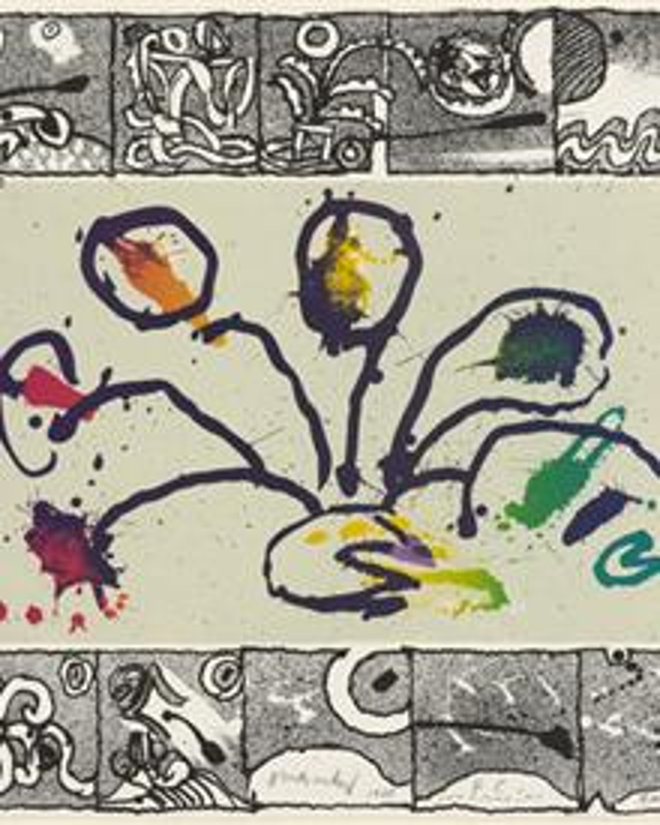

In [12]:
from PIL import Image
img = Image.open(img_pth).convert("RGB")
img.resize((img.width*3, img.height*3))

### EXPLAIN THE IMAGE

In [13]:
out = get_prediction(run=run, case_id=test_instance.value)
pred_idx = out[SessionStateKey.LOGITS].argmax().cpu().item()
pred_class = idx2class[pred_idx]
overlayed_image = explainer.explain_image(
            img_path=img_pth,
            model=run.model,
            reference_feats=out[SessionStateKey.GRAPH_FEATS],
            target=pred_idx,
            overlayed=True,
        )

/home/raffaele/art/contrastive-artwork-classification/.venv/lib/python3.10/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


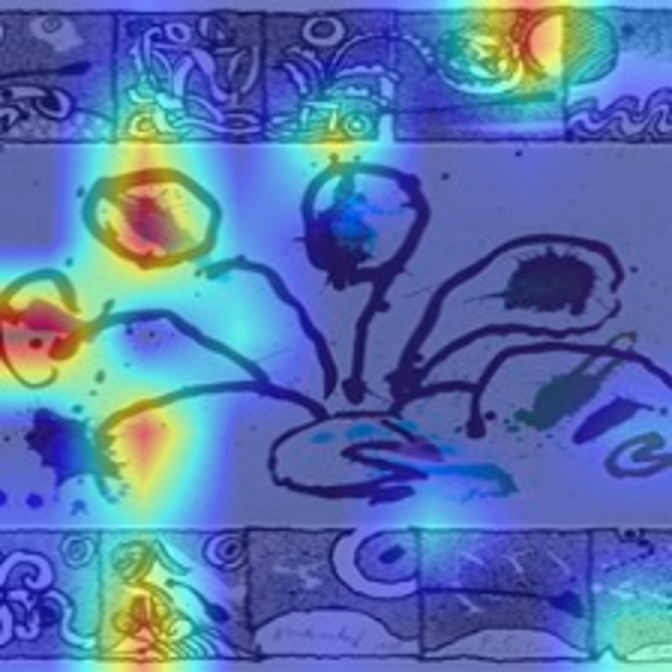

In [14]:
ov = Image.fromarray(overlayed_image, "RGB")
ov.resize((ov.width*3, ov.height*3))

In [15]:
f"Explaination of the image for class {pred_class}"

'Explaination of the image for class lyrical abstraction'

### EXPLAIN THE GRAPH

In [16]:
explanation = explainer.explain_graph(
    model=run.model,
    graph=run.graph,
    reference_feats=out[SessionStateKey.IMG_FEATS].detach(),
    target_node=class2idx[pred_class],
    algo=ArtGraphCaptumExplainer(GraphIntegratedGradients, graph=run.graph),
    algo_kwargs=dict(
        explanation_type="model",
        node_mask_type="attributes",
        edge_mask_type="object",
        model_config=dict(
            mode="multiclass_classification",
            task_level="node",
            return_type="raw",
        ),
        threshold_config=ThresholdConfig(threshold_type="topk", value=100),
    ),
)
explainer.plot_explanation(explanation, run.graph.metadata(), run.graph)


GraphWidget(layout=Layout(height='800px', width='100%'))

In [17]:
from tqdm import tqdm
correct_case_ids = set()
for case_id in tqdm(range(len(run.test_loader.dataset))):
    image_style = get_style_by_case_id(run=run, case_id=case_id)
    out = get_prediction(run=run, case_id=case_id)
    pred_idx = out[SessionStateKey.LOGITS].argmax().cpu().item()
    pred_class = idx2class[pred_idx]
    if image_style == pred_class:
        #print(f"{image_style} è uguale a {pred_class} per l'immagine {case_id}")
        correct_case_ids.add(case_id)

    

100%|██████████| 11647/11647 [06:05<00:00, 31.84it/s]


In [18]:
correct_case_ids

{7,
 61,
 87,
 100,
 107,
 129,
 182,
 200,
 223,
 240,
 317,
 329,
 358,
 394,
 419,
 427,
 451,
 481,
 495,
 496,
 522,
 528,
 546,
 572,
 582,
 583,
 756,
 769,
 803,
 804,
 880,
 991,
 1052,
 1056,
 1070,
 1113,
 1127,
 1153,
 1170,
 1197,
 1230,
 1325,
 1369,
 1373,
 1390,
 1404,
 1406,
 1419,
 1445,
 1450,
 1525,
 1533,
 1616,
 1642,
 1696,
 1747,
 1759,
 1788,
 1799,
 1840,
 1844,
 1854,
 1975,
 1977,
 1980,
 2035,
 2052,
 2109,
 2126,
 2140,
 2158,
 2162,
 2186,
 2204,
 2274,
 2283,
 2284,
 2288,
 2321,
 2336,
 2346,
 2355,
 2385,
 2387,
 2389,
 2454,
 2476,
 2522,
 2592,
 2616,
 2760,
 2858,
 2915,
 2951,
 2996,
 3043,
 3069,
 3076,
 3114,
 3181,
 3228,
 3229,
 3243,
 3251,
 3260,
 3284,
 3299,
 3304,
 3327,
 3341,
 3478,
 3528,
 3651,
 3751,
 3779,
 3806,
 3825,
 3882,
 3886,
 3955,
 3980,
 3997,
 4016,
 4017,
 4042,
 4142,
 4146,
 4157,
 4203,
 4204,
 4235,
 4254,
 4277,
 4301,
 4302,
 4324,
 4331,
 4334,
 4349,
 4421,
 4425,
 4455,
 4497,
 4539,
 4557,
 4574,
 4601,
 4604,


In [19]:
import random
random.choice(list(correct_case_ids))

11437

In [20]:
len(correct_case_ids)

373